#**GENRE DETECTION VIA AUDIO PREPROCESSING AND MACHINE LEARNING 🔍**


Caro avaliador, será necessário baixar o dataset do kaggle. Esse processo é bem intuitivo ao seguir o código. Embora a abordagem não seja a mais prudente em termos de segurança, decidimos utilizá-la pela sua comodidade. Confiamos na sua boa intenção 😀.

A execução do notebook é custosa na etapa de extração de features, sobretudo a divisão dos áudios em sinal harmônico e percussivo. O notebook executa completo em 20 minutos.

##**IMPORTS**

In [ ]:
!pip install -q opendatasets
!pip install librosa

In [ ]:
import opendatasets as od
import pandas as pd
import IPython.display as ipd
import librosa
import numpy as np
import os
import tqdm
import threading
from sklearn.base import BaseEstimator, TransformerMixin
from multiprocessing import Process, Manager, Pool

In [ ]:
od.download('https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification')



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: otaviohbfrancisco
Your Kaggle Key: ··········


100%|██████████| 1.21G/1.21G [00:18<00:00, 70.9MB/s]


In [ ]:
os.remove('/content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav')

## **PREPROCESSING** 🧹

In [ ]:
%cd '/content/gtzan-dataset-music-genre-classification/Data/genres_original'

/content/gtzan-dataset-music-genre-classification/Data/genres_original


In [ ]:
folders = os.listdir()
CONST_SR = 18000 #devido ao tempo de execução, baixamos o sr 18K. Qual maior o SR, maior a "resolução" dos áudios.

In [ ]:
def fullname(f, s):
  fullname = f'/content/gtzan-dataset-music-genre-classification/Data/genres_original/{f}/{s}'
  return fullname

# Função para gerar o caminho completo de um arquivo de música.

In [ ]:
songs = []
i = 0
for folder in folders:
  %cd '/content/gtzan-dataset-music-genre-classification/Data/genres_original/{folder}'
  song_list = os.listdir()
  fs = [fullname(folder, s) for s in song_list]
  songs.append(fs)
  i += 1

  # Loop para iterar sobre as pastas de gênero e coletar as listas de arquivos de música.


/content/gtzan-dataset-music-genre-classification/Data/genres_original/blues
/content/gtzan-dataset-music-genre-classification/Data/genres_original/metal
/content/gtzan-dataset-music-genre-classification/Data/genres_original/classical
/content/gtzan-dataset-music-genre-classification/Data/genres_original/hiphop
/content/gtzan-dataset-music-genre-classification/Data/genres_original/jazz
/content/gtzan-dataset-music-genre-classification/Data/genres_original/disco
/content/gtzan-dataset-music-genre-classification/Data/genres_original/rock
/content/gtzan-dataset-music-genre-classification/Data/genres_original/pop
/content/gtzan-dataset-music-genre-classification/Data/genres_original/country
/content/gtzan-dataset-music-genre-classification/Data/genres_original/reggae


**Foi aplicado paralelismo para agilizar o tempo de execução.**

In [ ]:
manager = Manager()

jazz =  manager.list()
rock = manager.list()
reggae = manager.list()
disco = manager.list()
classical = manager.list()
hiphop = manager.list()
country = manager.list()
pop = manager.list()
metal = manager.list()
blues = manager.list()

song_data = [jazz, rock, reggae, disco, classical, hiphop, country, pop, metal, blues]

# Inicialização dos gerenciadores de lista para cada gênero musical.

A função **HPSS** (Harmonic-Percussive Source Separation) é responsável por dividir um sinal de áudio no domínio do tempo em dois componentes: o sinal harmônico e o sinal percussivo. Essa separação é essencial para a extração eficiente de determinadas características, já que quando os sinais estão juntos, eles se “contaminam” e interferem mutuamente. Internamente, O HPSS faz uso da Transformada de Fourier de Curto Prazo (STFT) para decompor o sinal e, em seguida, a inversa da STFT (ISTFT) para obter os componentes harmônicos e percussivos separados.

In [ ]:
def getHarmonicPercussive(song):

  y, sr = librosa.load(song, sr =CONST_SR)
  y = y[:(int(np.ceil(len(y)/3)))]
  yh, yp = librosa.effects.hpss(y)
  y_arr = np.vstack((y,yh,yp))

  return y_arr

In [ ]:
def treatGenre(name_arr):
  for filename in name_arr:
    arr = filename.split('/')
    genre = arr[5]

    arr = getHarmonicPercussive(filename)

    if(genre == 'country'): country.append(arr)
    if(genre == 'jazz'): jazz.append(arr)
    if(genre == 'pop'): pop.append(arr)
    if(genre == 'metal'): metal.append(arr)
    if(genre == 'disco'): disco.append(arr)
    if(genre == 'reggae'): reggae.append(arr)
    if(genre == 'classical'): classical.append(arr)
    if(genre == 'hiphop'): hiphop.append(arr)
    if(genre == 'blues'): blues.append(arr)
    if(genre == 'rock'): rock.append(arr)

  # Função para processar cada arquivo de música e atribuí-lo à lista correspondente ao gênero musical.

In [ ]:
processes = []
for genre_arr in songs:
    process = Process(target=treatGenre, args=(genre_arr,))
    processes.append(process)
    process.start()

for process in processes:
    process.join()

# Loop para esperar que todos os processos terminem antes de prosseguir.


## **CONSTRUINDO O DATASET : 📚**

* Feature Extraction e estruturação dos dados.

In [ ]:
songs_df = pd.DataFrame()

In [ ]:
y_values = []
yh_values = []
yp_values = []

i = 0
labels = []
genre_names = ['jazz', 'rock', 'reggae', 'disco', 'classical', 'hiphop', 'country', 'pop', 'metal', 'blues']

for genre in song_data:
  for song in genre:
    y_values.append(song[0])
    yh_values.append(song[1])
    yp_values.append(song[2])
    labels.append(genre_names[i])
  i += 1

# Inicialização e loop para iterar sobre os dados de músicas de cada gênero e extrair os valores de áudio, atribuindo-os às listas correspondentes.


In [ ]:
songs_df['y_values'] = y_values
songs_df['yh_values'] = yh_values
songs_df['yp_values'] = yp_values
songs_df['label'] = labels

# Atribuição dos valores de áudio e dos labels aos respectivos dataframes.

O ***tempo*** (Batimentos por minuto) é uma grandeza de define o ritmo de uma música, e é bem destinta entre os gêneros, tornando-se uma feature interessante de ser extraída. O tempo, assim como outras carcterísticas, é obtido a partir da identificação de padrões repetitivos resultantes do uso da transformada de Fourier.

Analogamente, considerou-se que os cromagramas, que indicam a densidade de cada nota no áudio, seriam um bom conjunto de características a serem analisadas. Fazendo uma comparação :

O jazz e o blues tendem a ter acordes menores com sétimas.
O metal costuma apresentar acordes maiores com quintas.
O pop utiliza predominantemente acordes maiores puros.

No entanto, apesar dos benefícios potenciais, constatou-se empiricamente que a adição dessas características ao conjunto de dados não teve impacto significativo no desempenho do modelo


In [ ]:
def tempofunc(y_perc):
  tempo, beat_frames = librosa.beat.beat_track(y=y_perc, sr=CONST_SR)
  return tempo

def get_chromagram(y_harm):
  chroma = librosa.feature.chroma_cqt(y=y_harm, sr=CONST_SR)
  chr_means = []
  for note in chroma:
    chr_means.append(np.mean(note))

  return chr_means

Os **MFCCS** são um excelente conjunto de features para descrever um áudio. Comumente são úteis para extrair a informação de timbre, o que é muito interessante se tratando do domínio em questão (música).

O processo de extração dos mfccs se dá da seguinte forma:
* Aplicação da transformada de fourier no sinal.
* Mapeamento da potência de janelas do sinal à escala MEL.
* Aplicação do logaritmo nas frequências mel
* Aplicação de uma DCT (Discrete Cosine Transform) nessas frequências, interpretando-as como um sinal.
* Os MFCCS serão portanto as amplitudes dos coeficientes dessa transformada.

**Spectral Centroid** define o "centro de massa" do áudio (brilho dos som), que também é interessante para nossa análise, haja vista a grande diferença entre os dados de diferentes gêneros musicais.

Uma música tem mais "brilho" se tem mais frequências agudas, como o pop em relação ao metal, por exemplo.

**Zero Crossing:** Conta quantas vezes o sinal cruza o eixo zero. Ajuda a entender mudanças de direção no som. Útil para classificar estilos musicais.
**RMS (Root Mean Square):** Mede a energia média do sinal. Indica o quão alto ou suave é o som. Ambas são importantes pois gêneros diferentes possuem BPM e RMS específicos.

In [ ]:
def get_zero_crossings(y_full):
  zr_cross = librosa.zero_crossings(y=y_full, pad = False)
  zr_cross = sum(zr_cross)
  return zr_cross

def get_mfccs(y_full):
  mfccs = librosa.feature.mfcc(y=y_full, sr=CONST_SR)
  # if(mfccs.shape != (20, 704)):
  #   print(mfccs.shape)
  return mfccs

def get_spec_cent(y_full):
  spectral_centroids = librosa.feature.spectral_centroid(y = y_full, sr=CONST_SR)
  return spectral_centroids

def get_spec_rolloff(y_full):
  return librosa.feature.spectral_rolloff(y=y_full)

def get_rms(y_full):
  return librosa.feature.rms(y=y_full)

In [ ]:
songs_df['zero_cross'] = songs_df['y_values'].apply(get_zero_crossings)
songs_df['spec_centroids'] = songs_df['y_values'].apply(get_spec_cent)
songs_df['mfccs'] = songs_df['y_values'].apply(get_mfccs)
songs_df['rms'] = songs_df['y_values'].apply(get_rms)
songs_df['tempo'] = songs_df['yp_values'].apply(tempofunc)
songs_df['spectral_rolloff'] = songs_df['y_values'].apply(get_spec_rolloff)

In [ ]:
songs_df['spectral_rolloff_mean'] = songs_df['spectral_rolloff'].apply(np.mean)
songs_df['spectral_rolloff_std'] = songs_df['spectral_rolloff'].apply(np.std)
songs_df['rms_mean'] = songs_df['rms'].apply(np.mean)
songs_df['rms_std'] = songs_df['rms'].apply(np.std)
songs_df = songs_df.drop(columns=['spectral_rolloff','rms'])


## **MFCCS Treatment : 🎶**

* Estruturando os dados no dataset.

In [ ]:
def getArrays(row):
  data = []
  for arr in row:
    data.append(np.array(arr))

  return data

# Função para converter as listas de arrays em arrays NumPy.

In [ ]:
mfccs_expanded = songs_df['mfccs'].apply(getArrays)

data = []
data_row = []

for row in mfccs_expanded:
  data_arr = []
  for array in row:
    data_arr.append(np.mean(array))
    data_arr.append(np.std(array))

  data_row.append(data_arr)


mfcc_df = pd.DataFrame()

mean_columns = ['mfcc_mean'+'_{}'.format(i) for i in range(20)]
std_columns = ['mfcc_std'+'_{}'.format(i) for i in range(20)]

all_cols = []
for i in range(len(mean_columns)):
  all_cols.append(mean_columns[i])
  all_cols.append(std_columns[i])

mfcc_df[all_cols] = data_row

# Expansão dos dados de MFCCs para calcular a média e o desvio padrão de cada coeficiente.

In [ ]:
songs_df_treated = songs_df.copy()
songs_df_treated= songs_df_treated.drop(columns='mfccs')
songs_df_treated = pd.concat([songs_df_treated, mfcc_df], axis=1)

# Criação de um dataframe para armazenar as médias e os desvios padrão dos coeficientes MFCC e drop da columa 'mfccs' original

## **Other features :** 🔎

A **Spectral Bandwith** é a largura de banda do espectro e define o tamanho da variação entre os espectros. Diferentes gêneros musicais tendem a ter perfis espectrais distintos, com variações na distribuição de energia em diferentes faixas de frequência, sendo assim um potencial bom indicativo pro classificador.

In [ ]:
def getSpecBand(y):
  return librosa.feature.spectral_bandwidth(y=y, sr=CONST_SR)

def getSpecFlat(y):
  return librosa.feature.spectral_flatness(y=y)

def getSpecCont(y):
  return librosa.feature.spectral_contrast(y=y)

def getTonnetz(y):
  return librosa.feature.tonnetz(y=y, sr=CONST_SR)

In [ ]:
songs_df_treated['spectral_bandwidth'] = songs_df_treated['y_values'].apply(getSpecBand)
songs_df_treated['spectral_flatness'] = songs_df_treated['y_values'].apply(getSpecFlat)
songs_df_treated['spectral_contrast'] = songs_df_treated['y_values'].apply(getSpecCont)
songs_df_treated['tonnetz'] = songs_df_treated['y_values'].apply(getTonnetz)


O **Tonnetz** é como um mapa musical que conecta acordes. Essas conexões mostram como os acordes estão relacionados. É útil para entender harmonia e classificar os gêneros.

In [ ]:
tonnetz_expanded = songs_df_treated['tonnetz'].apply(getArrays)

data = []
data_row = []

for row in tonnetz_expanded:
  data_arr = []
  for array in row:
    data_arr.append(np.mean(array))
    data_arr.append(np.std(array))

  data_row.append(data_arr)


tonnetz_df = pd.DataFrame()

mean_columns = ['tonnetz_mean'+'_{}'.format(i) for i in range(6)]
std_columns = ['tonnetz_std'+'_{}'.format(i) for i in range(6)]

all_cols = []
for i in range(len(mean_columns)):
  all_cols.append(mean_columns[i])
  all_cols.append(std_columns[i])

tonnetz_df[all_cols] = data_row

In [ ]:
songs_df_treated= songs_df_treated.drop(columns='tonnetz')
songs_df_treated = pd.concat([songs_df_treated, tonnetz_df], axis=1)

In [ ]:
songs_df_treated['spectral_bandwidth_mean'] = songs_df_treated['spectral_bandwidth'].apply(np.mean)
songs_df_treated['spectral_flatness_mean'] = songs_df_treated['spectral_flatness'].apply(np.mean)
songs_df_treated['spectral_contrast_mean'] = songs_df_treated['spectral_contrast'].apply(np.mean)
songs_df_treated['spectral_bandwidth_std'] = songs_df_treated['spectral_bandwidth'].apply(np.std)
songs_df_treated['spectral_flatness_std'] = songs_df_treated['spectral_flatness'].apply(np.std)
songs_df_treated['spectral_contrast_std'] = songs_df_treated['spectral_contrast'].apply(np.std)

In [ ]:
songs_df_treated = songs_df_treated.drop(columns=['spectral_bandwidth','spectral_flatness','spectral_contrast'])

## **Other types of data treatment : ⚙️**

In [ ]:
songs_df_treated2 = songs_df_treated.drop(columns=['y_values',	'yh_values','yp_values'])
# Remoção das colunas 'y_values', 'yh_values' e 'yp_values' do dataframe tratado.

In [ ]:
songs_df_treated2['spec_centroids_std'] = songs_df_treated2['spec_centroids'].apply(np.std)
songs_df_treated2['spec_centroids_mean'] = songs_df_treated2['spec_centroids'].apply(np.mean)


In [ ]:
songs_df_treated2 = songs_df_treated2.drop(columns='spec_centroids')

In [ ]:
def renameLabel(label):

  if(label == 'country'): return 0
  if(label == 'jazz'): return 1
  if(label == 'pop'):return 2
  if(label == 'metal'):return 3
  if(label == 'disco'): return 4
  if(label == 'reggae'):return 5
  if(label == 'classical'): return 6
  if(label == 'hiphop'): return 7
  if(label == 'blues'): return 8
  if(label == 'rock'): return 9

# Função para renomear os labels dos gêneros para valores numéricos.

In [ ]:
songs_df_treated2['label'] = songs_df_treated2['label'].apply(renameLabel)

## **Remoção de Outliers : 🗑️**

In [ ]:
from scipy import stats
import numpy as np

for feature in songs_df_treated2.columns:
    if np.issubdtype(songs_df_treated2[feature].dtype, np.number):
        z_scores = np.abs(stats.zscore(songs_df_treated2[feature]))
        songs_df_treated2 = songs_df_treated2[(z_scores < 3)]

# Loop para calcular os escores Z para cada característica numérica e remover os outliers do dataframe tratado.

### Matriz de Correlação

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# correlation_matrix = songs_df_treated2.corr()

# plt.figure(figsize=(12, 9))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
# plt.show()

## **SMOTE** : 🔄

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
X = songs_df_treated2.drop(columns='label').values
y = songs_df_treated2['label'].values

In [ ]:
len(X)

610

In [ ]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)


In [ ]:
len(X_res)

900

## **Visualização de algumas características extraídas : 🎵**

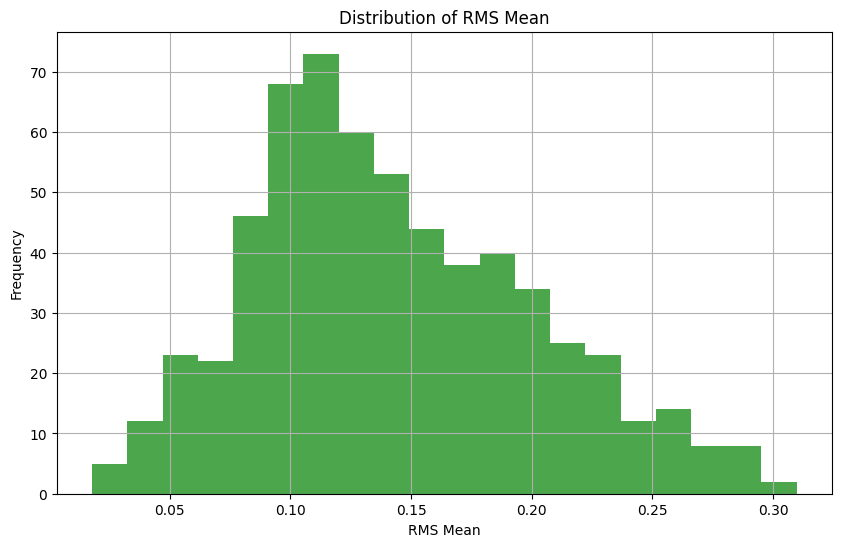

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(songs_df_treated2['rms_mean'], bins=20, color='green', alpha=0.7)
plt.xlabel('RMS Mean')
plt.ylabel('Frequency')
plt.title('Distribution of RMS Mean')
plt.grid(True)
plt.show()


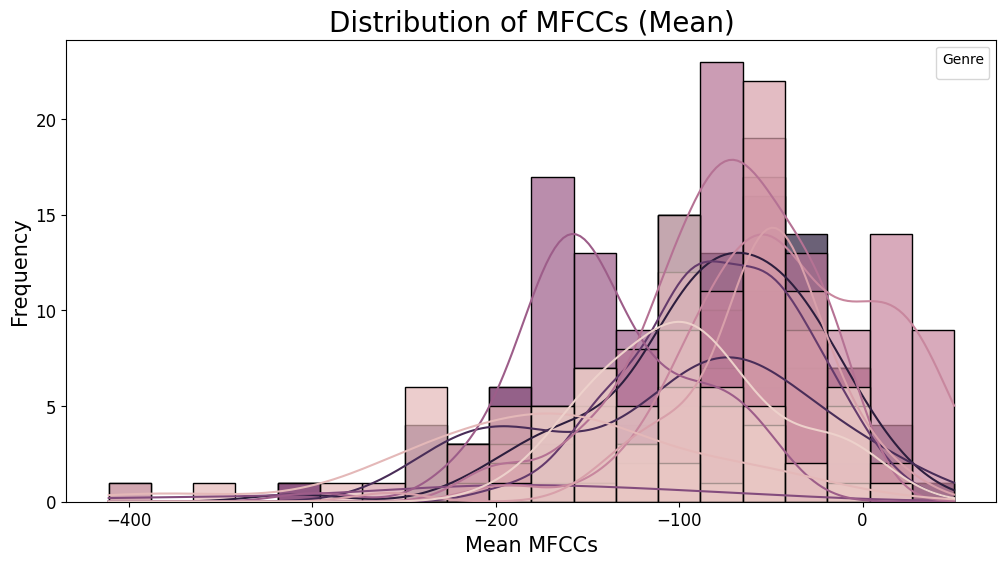

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(data=songs_df_treated2, x='mfcc_mean_0', hue='label', bins=20, kde=True, alpha=0.7)
plt.title('Distribution of MFCCs (Mean)', fontsize=20)
plt.xlabel('Mean MFCCs', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Genre')
plt.savefig("MFCC_Distribution.png")
plt.show()


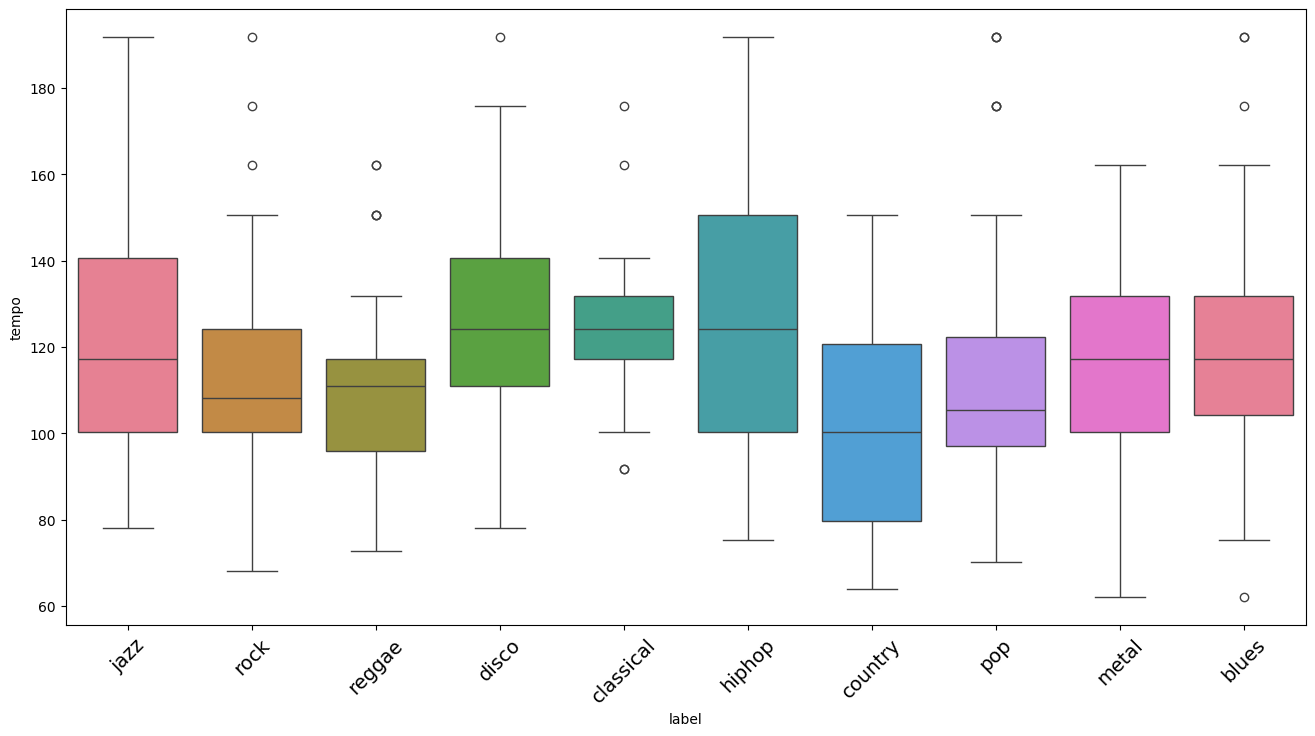

In [ ]:
x = songs_df_treated2[["label", "tempo"]]
plt.figure(figsize=(16, 8))

boxplot = sns.boxplot(x="label", y="tempo", hue="label", data=x, palette='husl', legend=False)

boxplot.set_xticks(range(len(genre_names)))
boxplot.set_xticklabels(labels=genre_names, fontsize=14, rotation=45)
boxplot.set_xticklabels(labels=genre_names, fontsize=14, rotation=45)

plt.savefig("BPM_Boxplot.png")
plt.show()


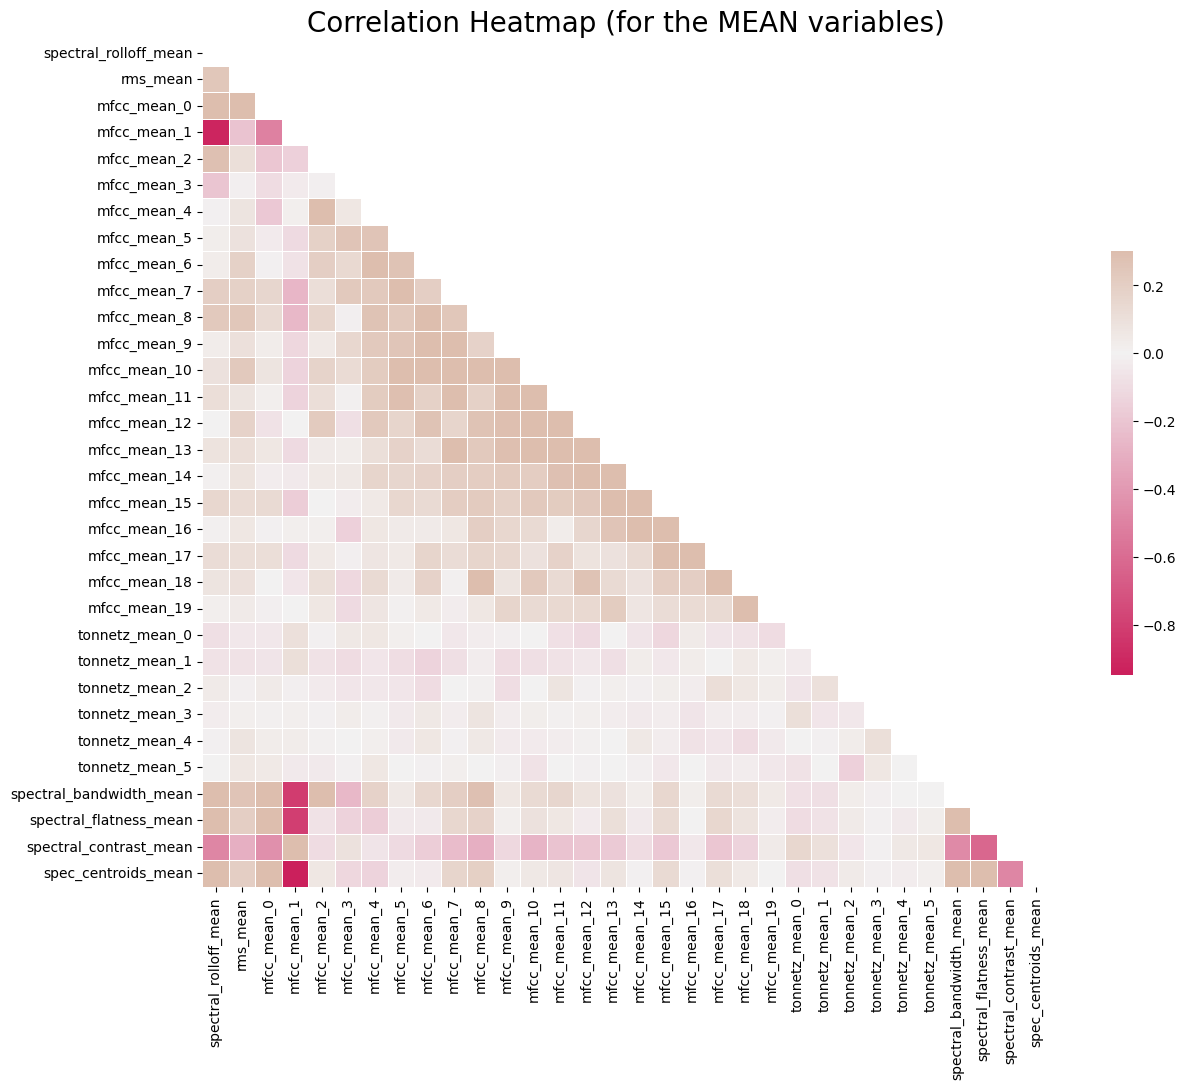

In [ ]:
import seaborn as sns

spike_cols = [col for col in songs_df_treated2.columns if 'mean' in col]
corr = songs_df_treated2[spike_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(16, 11))
cmap = sns.diverging_palette(0, 25, as_cmap=True, s=90, l=45, n=5)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation Heatmap (for the MEAN variables)', fontsize=20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.savefig("Corr_Heatmap.png")
plt.show()

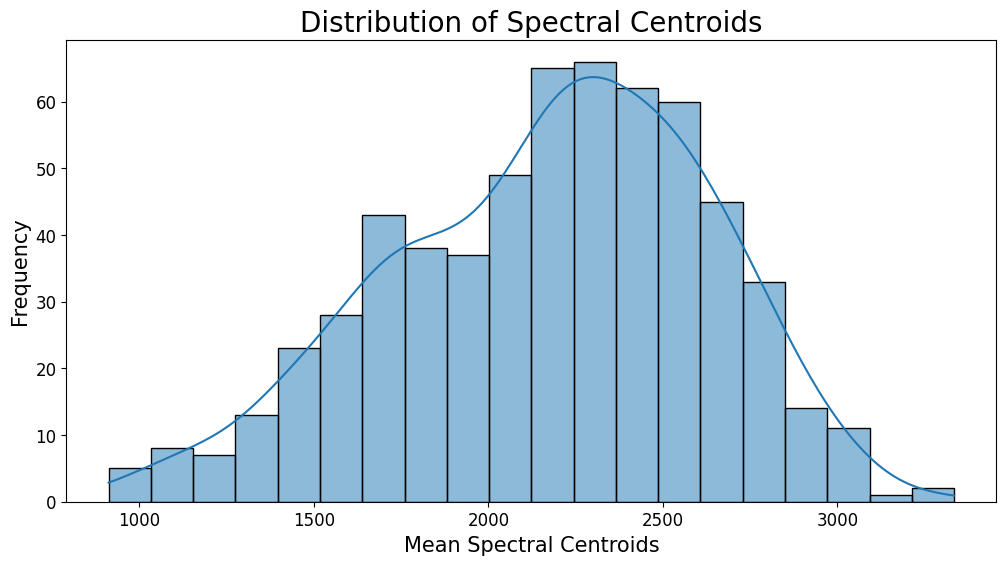

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.histplot(data=songs_df_treated2, x='spec_centroids_mean', bins=20, kde=True)
plt.title('Distribution of Spectral Centroids', fontsize=20)
plt.xlabel('Mean Spectral Centroids', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Spectral_Centroids_Distribution.png")
plt.show()

## **MODELOS : 🧠**

In [ ]:
import xgboost as xgb
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix, f1_score, recall_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scalerMinMax = MinMaxScaler()
X_res  = scalerMinMax.fit_transform(X_res)

In [ ]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res, y_res , test_size=0.2, random_state=42)

In [ ]:
def show_results(y_test, predictions):
  print('Accuracy score:', accuracy_score(y_test, predictions))
  # print('f1 score:', f1_score(y_test, predictions))
  # print('recall score:', recall_score(y_test, predictions))

  font = {'family' : 'serif', 'weight' : 'bold', 'size':18}
  plt.rc('font', **font)
  disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions), display_labels=None)
  disp.plot()
  plt.show()

## **XGB Classifier 📊**

Accuracy score: 0.8


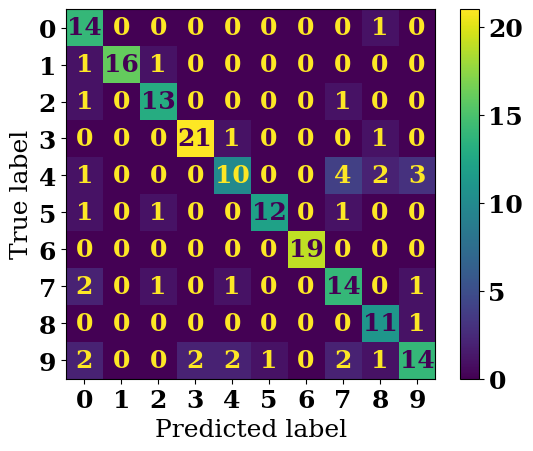

In [ ]:
xgb_classifier = xgb.XGBClassifier(eta=0.1)
xgb_classifier = xgb_classifier.fit(X_train_res, y_train_res)

xgb_pred = xgb_classifier.predict(X_test_res)
show_results(y_test_res, xgb_pred)

In [ ]:
genre_names

['jazz',
 'rock',
 'reggae',
 'disco',
 'classical',
 'hiphop',
 'country',
 'pop',
 'metal',
 'blues']

## **KNN 📊**

Accuracy score: 0.6944444444444444


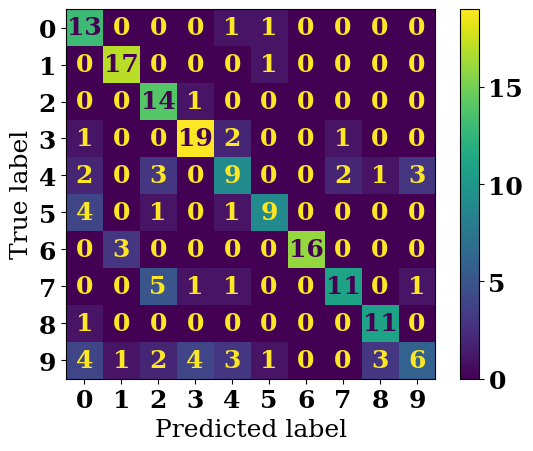

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knearest = KNeighborsClassifier(n_neighbors = 17)
knearest = knearest.fit(X_train_res, y_train_res)
knn_pred = knearest.predict(X_test_res)
show_results(y_test_res, knn_pred)

In [ ]:
len(X_test_res)

180

## **CatBoost 📊**

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.4 MB/s eta 0:00:00


O **CatBoost** foi um modelo escolhido. Ele funciona treinando árvores de decisão de forma inteligente, considerando características categóricas e numéricas. Além disso, o CatBoost lida bem com poucos dados, o que é uma vantagem para o nosso classificador.

0:	learn: 2.0161806	total: 151ms	remaining: 3m 46s
300:	learn: 0.0339366	total: 1m	remaining: 4m 1s
600:	learn: 0.0178976	total: 1m 32s	remaining: 2m 18s
900:	learn: 0.0128745	total: 2m 6s	remaining: 1m 23s
1200:	learn: 0.0104969	total: 2m 40s	remaining: 39.8s
1499:	learn: 0.0090616	total: 3m 12s	remaining: 0us
Accuracy score: 0.8111111111111111


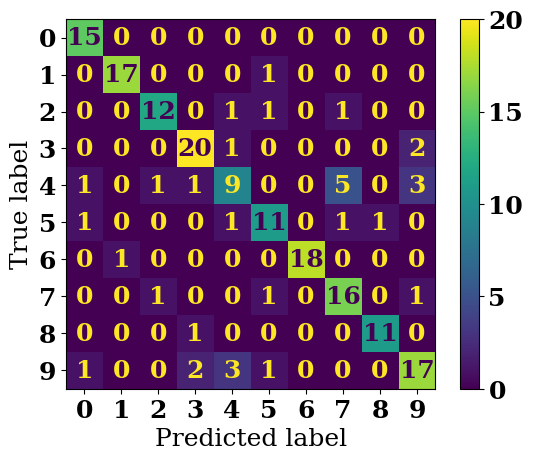

In [ ]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(iterations=1500, learning_rate=0.3, loss_function='MultiClass', random_state=42, verbose=300)
cat.fit(X_train_res, y_train_res)
cat_pred = cat.predict(X_test_res)

show_results(y_test_res, cat_pred)

O cross-validation é usado para avaliar o desempenho do modelo em diferentes conjuntos de dados. Os resultados agregados nos dão uma ideia de como o modelo se sairá em dados não vistos. Por motivos de tempo de execução, o cross-validation foi retirado do notebook, mas como demonstrado na apresentação, a acurácia média foi de aproximadamente 84%.